# Analyse de personnalité client - Modélisation

Ce notebook réalise l'analyse non supervisée du jeu de données issu de la **Customer Personality Analysis** disponible sur Kaggle.
Nous allons:
1. Charger et explorer les données
2. Nettoyer et prétraiter le jeu de données
3. Réduire la dimension avec une sélection de variables et une analyse factorielle
4. Appliquer trois méthodes de clustering (k-means, CAH, DBSCAN)
5. Comparer les résultats et profiler les groupes obtenus
6. Conclure

## 1. Chargement et exploration des données

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

df = pd.read_csv('../data/marketing_campaign.csv', sep='	')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


À supprimer après screen shot

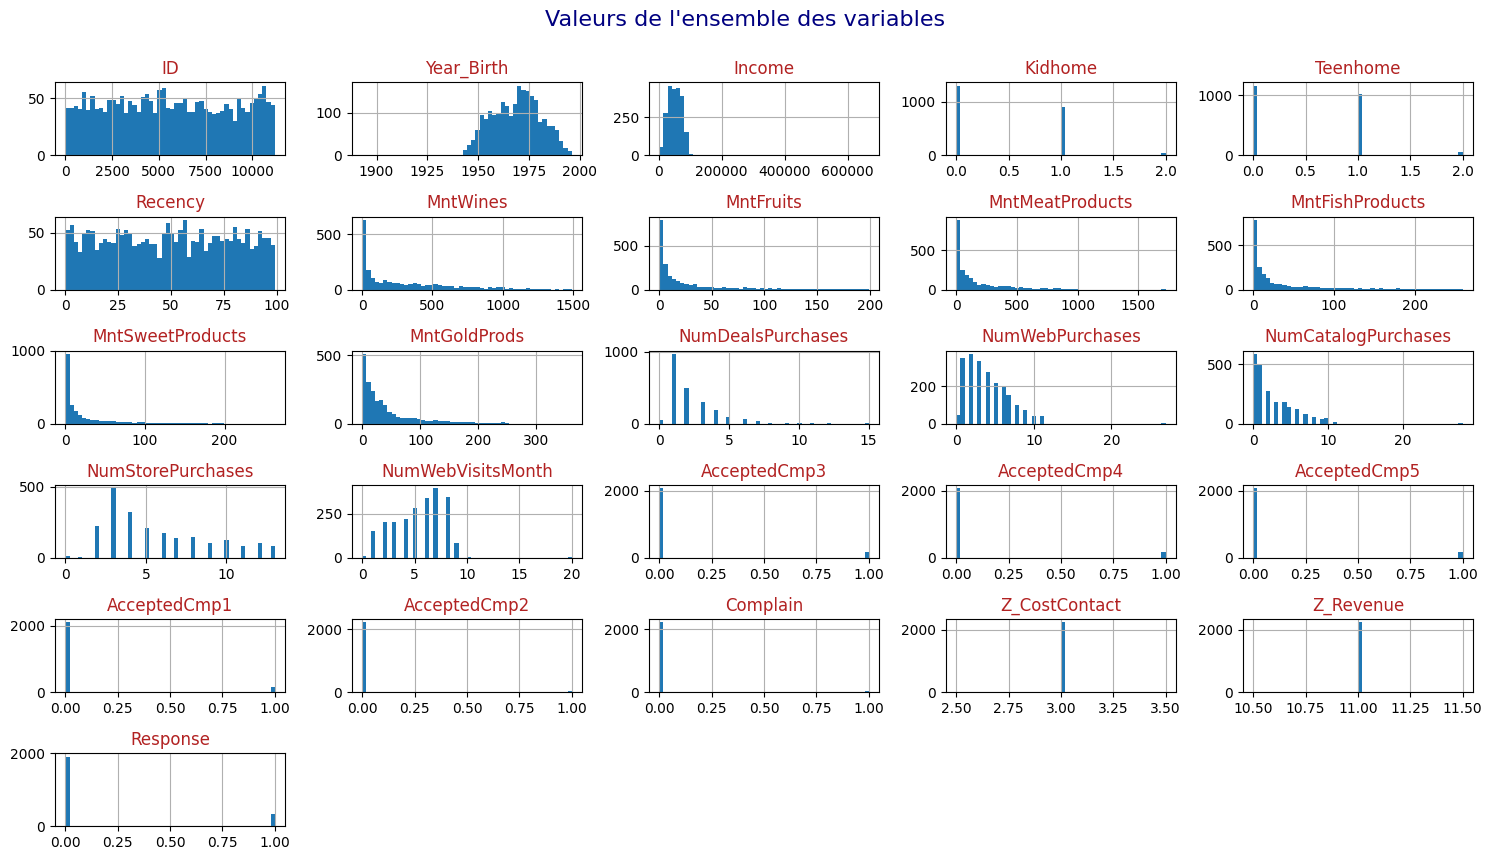

In [2]:
axes = df.hist(bins=50, figsize=(15,9))
plt.suptitle("Valeurs de l'ensemble des variables", fontsize=16, color="navy")
for ax in axes.ravel():
    ax.set_title(ax.get_title(), color='firebrick')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

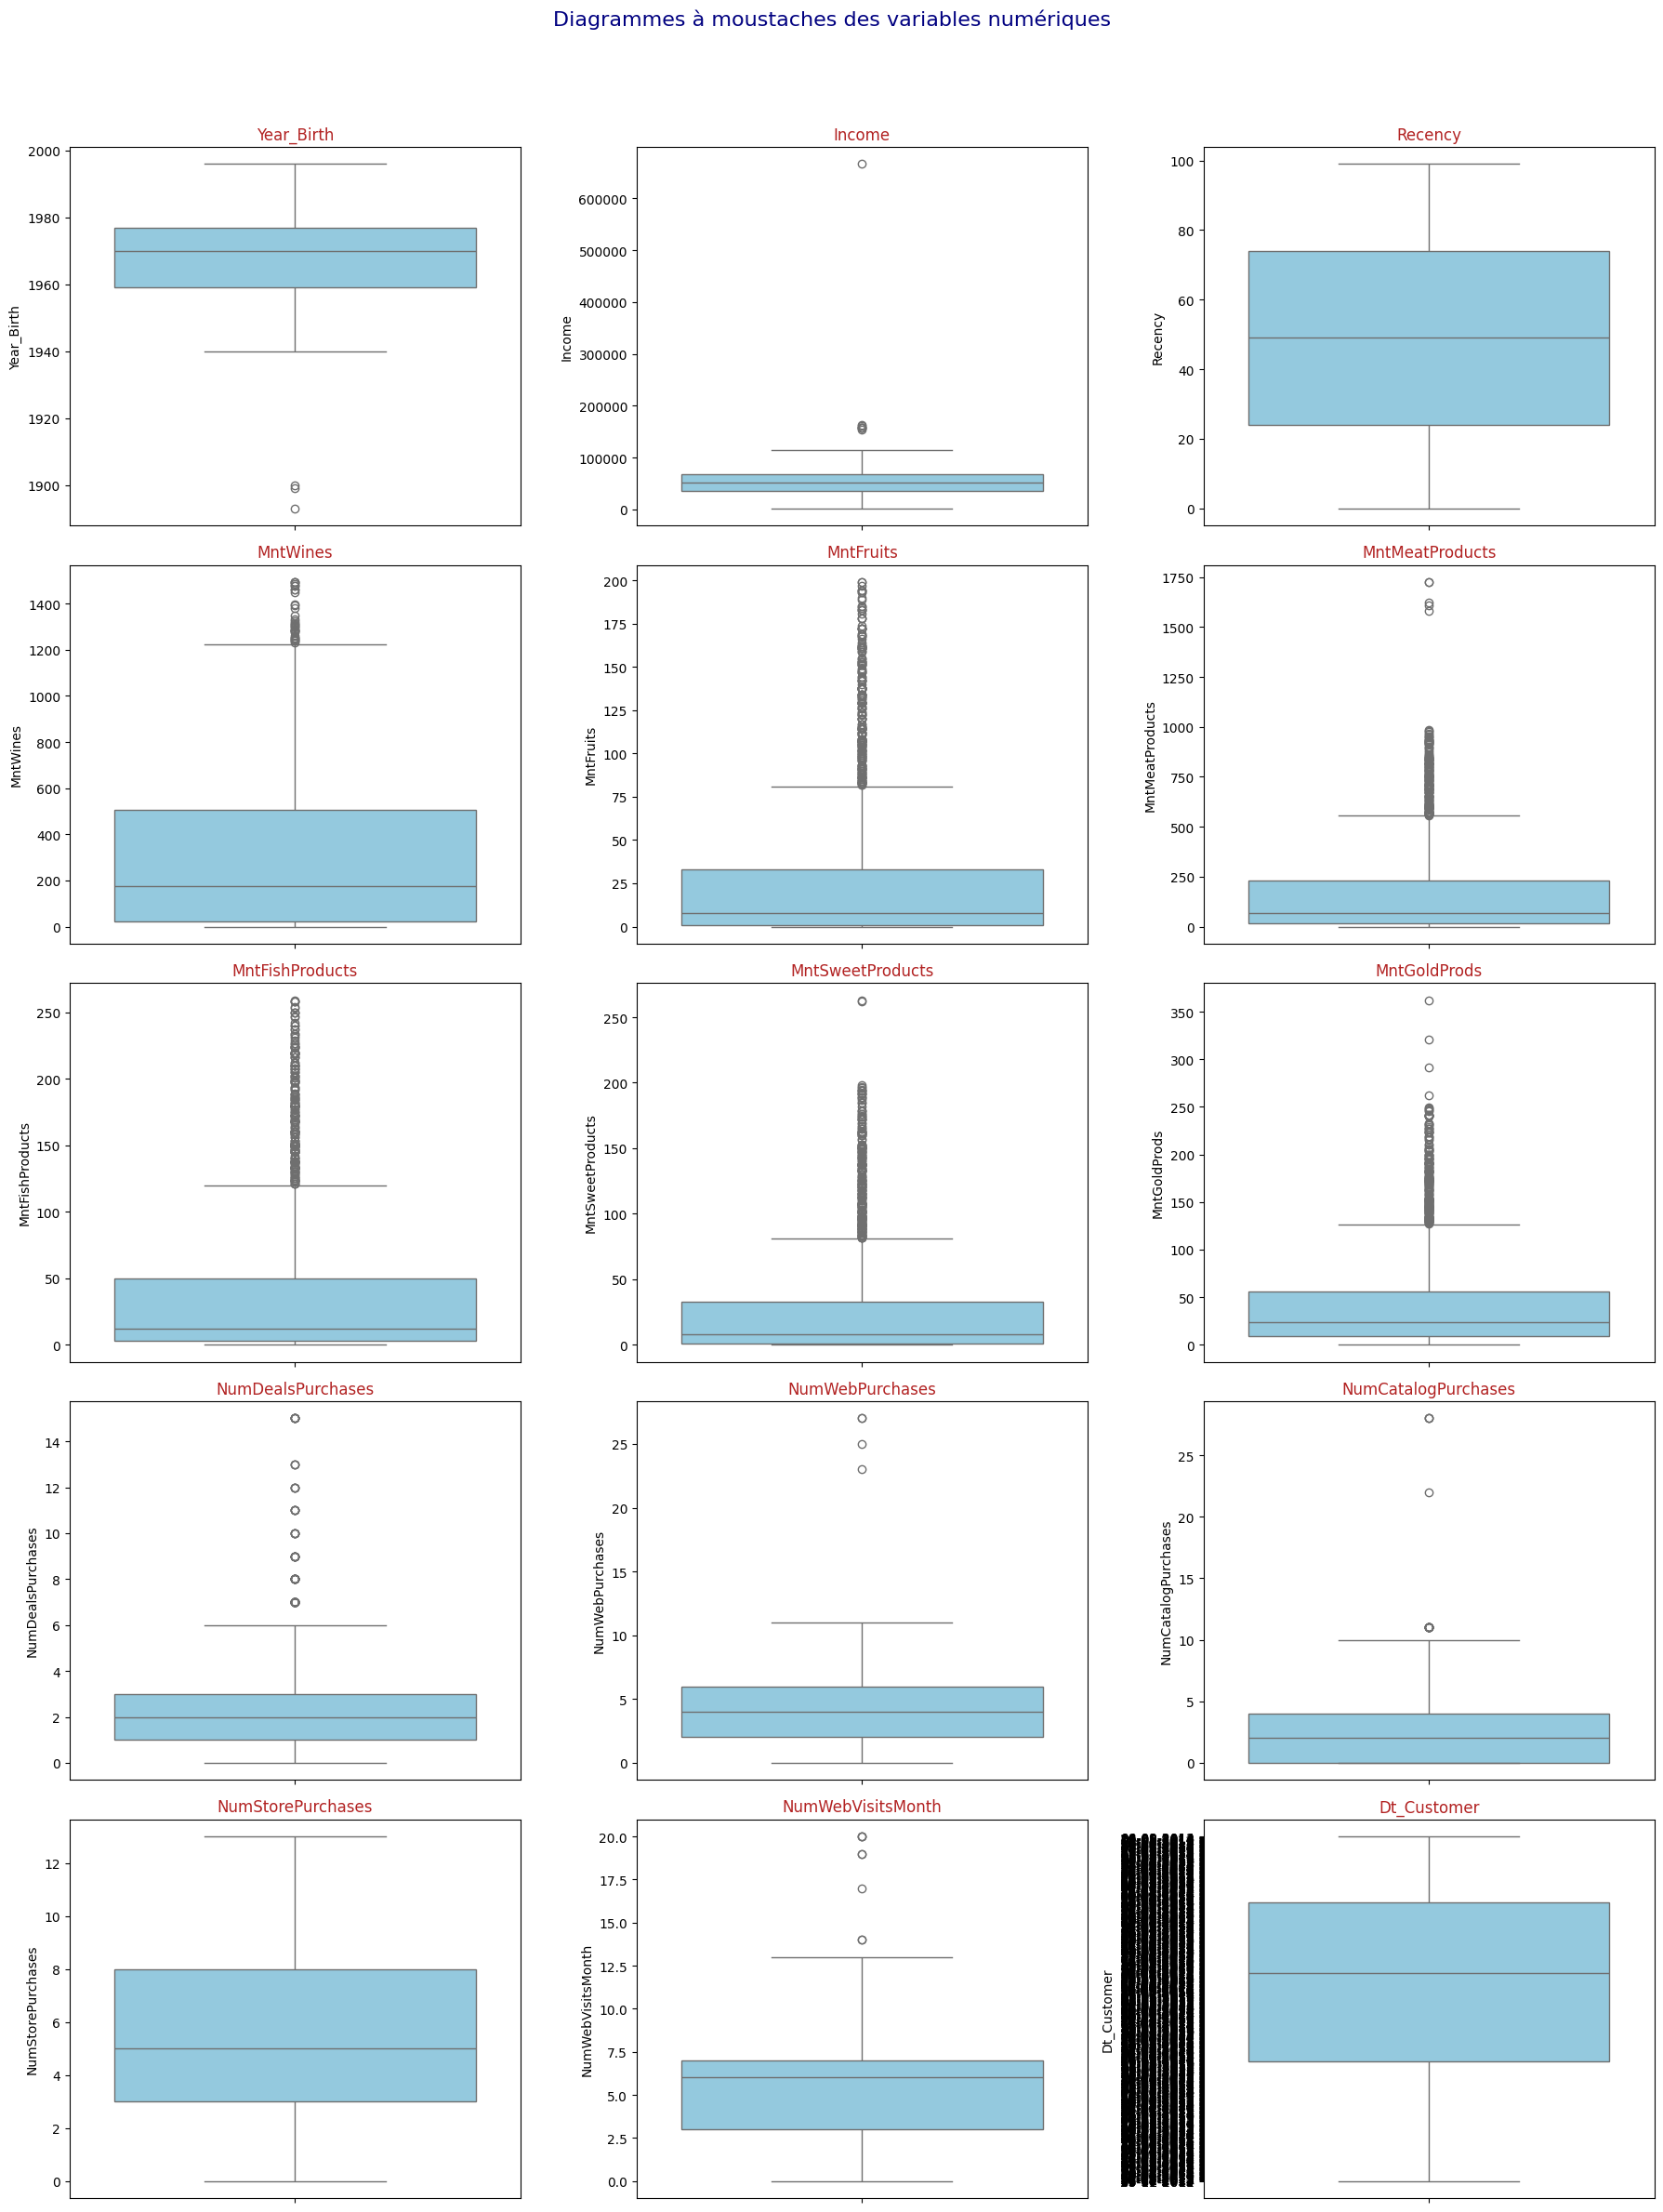

In [52]:
x_continue = [
    'Year_Birth', 'Income', 'Recency', 'MntWines', 'MntFruits',
    'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
    'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
    'NumCatalogPurchases', 'NumStorePurchases',
    'NumWebVisitsMonth', 'Dt_Customer'
]

n = len(x_continue)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
fig.suptitle("Diagrammes à moustaches des variables numériques", fontsize=16, color="navy")

for ax, col in zip(axes.ravel(), x_continue):
    sns.boxplot(data=df, y=col, ax=ax, color="skyblue")
    ax.set_title(col, color="firebrick")

# Masquer les axes inutilisés
for ax in axes.ravel()[len(x_continue):]:
    ax.set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Pour le nettoyage des données, plusieurs critères sont considérés. L'âge ou l'année de naissance (`Year_Birth`) doit être supérieur à 1930, avec une valeur minimale observée de 1893. Le revenu (`Income` ou `Revenu`) doit être inférieur à 140 000. Concernant les dépenses, les colonnes `Wine`, `Fruits` et `Fish` suivent une loi exponentielle. La dépense en `Meat` est généralement inférieure à 1250, bien que les valeurs supérieures restent cohérentes. Pour `Sweet`, la limite indicative est 200, mais là encore, les valeurs supérieures sont acceptables. La dépense en `Gold` est attendue en dessous de 300.

En ce qui concerne les canaux de commande, les valeurs pour `Web`, `Catalog` et `WebVisits` doivent rester inférieures à 15. Enfin, certaines colonnes comme `Z_Cost`, `Z_Revenue` et `ID` sont considérées comme non pertinentes et doivent être supprimées du jeu de données.

In [53]:
df = df[
    (df['Year_Birth'] > 1930) &
    (df['Income'] < 140000) &
    (df['MntMeatProducts'] < 1250) &
    (df['MntGoldProds'] < 300) &
    (df['MntSweetProducts'] < 300) &
    (df['NumWebPurchases'] < 15) &
    (df['NumCatalogPurchases'] < 15) &
    (df['NumWebVisitsMonth'] < 15)
]

df = df.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue'])


In [54]:
df.select_dtypes(include='object').columns

Index(['Education', 'Marital_Status', 'Dt_Customer'], dtype='object')

Dans le dataset, nous avons 3 features qui sont des strings, nous allons donc les transformer afin de pouvoir les exploiter

In [55]:
education_map = {
    '2n Cycle': 1,
    'Basic': 2,
    'Graduation': 3,
    'Master': 4,
    'PhD': 5
}
marital_map = {
    'Single': 1,
    'Divorced': 1,
    'Widow': 1,
    'Together': 2,
    'Married': 2,
    'Alone': 1,
    'Absurd': 1,
    'YOLO': 1
}


df['Education'] = df['Education'].map(education_map)
df['Marital_Status'] = df['Marital_Status'].map(marital_map)

# Ancienneté client
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_For_Days'] = (reference_date - df['Dt_Customer']).dt.days
df.drop(columns='Dt_Customer', inplace=True)

# Âge du client
df['Age'] = 2024 - df['Year_Birth']

# Total des dépenses par catégorie
expense_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spent'] = df[expense_cols].sum(axis=1)

# Total des achats
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 
                'NumStorePurchases', 'NumDealsPurchases']
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)

# Panier moyen
df['Avg_Order_Value'] = df['Total_Spent'] / (df['Total_Purchases'] + 1)

# Nombre total d'enfants
df['Total_Children'] = df['Kidhome'] + df['Teenhome']

# Acceptation campagnes marketing
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 
                'AcceptedCmp4', 'AcceptedCmp5', 'Response']
df['Total_Campaigns_Accepted'] = df[campaign_cols].sum(axis=1)


new_features = ['Education','Marital_Status', 'Customer_For_Days','Age', 'Total_Spent', 'Total_Purchases', 'Avg_Order_Value', 
            'Total_Children', 'Total_Campaigns_Accepted']

print("\nAperçu des colonnes transformées :")
print(df[new_features].head())


Aperçu des colonnes transformées :
   Education  Marital_Status  Customer_For_Days  Age  Total_Spent  \
0          3               1                663   67         1617   
1          3               1                113   70           27   
2          3               2                312   59          776   
3          3               2                139   40           53   
4          5               2                161   43          422   

   Total_Purchases  Avg_Order_Value  Total_Children  Total_Campaigns_Accepted  
0               25        62.192308               0                         1  
1                6         3.857143               2                         0  
2               21        35.272727               0                         0  
3                8         5.888889               1                         0  
4               19        21.100000               1                         0  


Afin de rendre les variables exploitables par les algorithmes d’apprentissage automatique, nous avons procédé aux transformations suivantes :

### Niveau d’étude (Education)

Le niveau d'étude a été transformé en variable ordinale selon un ordre croissant de qualification académique, allant de 1 à 5 :
- 2n Cycle	1
- Basic	2
- Graduation	3
- Master	4
- PhD	5

Cette transformation permet de modéliser l’évolution du niveau éducatif de manière cohérente pour les modèles.
### Statut marital (Marital_Status)
Nous avons regroupé les individus en deux grandes catégories :

- 1 : personnes vivant seules
- 2 : personnes en couple

Les modalités atypiques telles que Alone, Absurd ou YOLO ont été intégrées dans la catégorie des personnes seules.
Ce choix repose sur l’hypothèse qu’il s’agit de réponses ironiques ou critiques envers la vie de couple, que nous avons donc interprétées comme un rejet implicite d'une relation conjugale.

### Ancienneté du client (Dt_Customer)

La date d'inscription a été convertie en nombre de jours depuis l’inscription (Customer_For_Days) afin d’apporter une information temporelle exploitable par les modèles.

Ne disposant pas de la date de référence "aujourd’hui", nous avons utilisé la date d'inscription la plus récente du jeu de données comme point de référence.
L’ancienneté a été calculée comme suit :

Cette transformation permet d’intégrer la notion de fidélité du client dans l’analyse : 
Customer_For_Days = Date la plus récente - Dt_Customer

## Utilisation d'Isolation Forest

Isolation Forest détecte les outliers multivariés, c’est-à-dire des individus qui semblent normaux sur chaque variable isolée, mais incohérents lorsqu’on les combine.
Ces anomalies sont invisibles sur des histogrammes classiques, mais peuvent perturber les modèles.
L’algorithme isole rapidement ces points grâce à une logique d’arbres aléatoires qui les détectent.
Ici, nous avons écarté 112 valeurs abérantes multivariés qui n'auraient pas pu être visibles.

In [56]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_pred = iso.fit_predict(df.select_dtypes(include=[np.number]))
df['Outlier_IForest'] = outlier_pred
print(df['Outlier_IForest'].value_counts())

Outlier_IForest
 1    2085
-1     110
Name: count, dtype: int64


In [57]:
df = df[df['Outlier_IForest'] == 1].drop(columns='Outlier_IForest')

In [58]:
x_cat = df[['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 'AcceptedCmp3', 'AcceptedCmp4', 
    'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']]
x_cat.shape

(2085, 11)

In [59]:
x_continue = df[['Year_Birth', 'Income', 'Recency', 'MntWines', 'MntFruits',
'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
'NumCatalogPurchases', 'NumStorePurchases',
'NumWebVisitsMonth', 'Customer_For_Days']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_continue)
X_scaled_df = pd.DataFrame(X_scaled, columns=x_continue.columns, index=df.index)
# X_original = scaler.inverse_transform(X_scaled_df)
# X_original_df = pd.DataFrame(X_original, columns=x_continue.columns, index=df.index)

Merge_datframe you know ?

## 3. Réduction de dimension

In [75]:
from sklearn.decomposition import PCA
X_final = pd.concat([X_scaled_df], axis=1)
pca = PCA(n_components=0.9)
reduced_data = pca.fit_transform(X_final)
print('Nombre de composantes conservées :', pca.n_components_)

Nombre de composantes conservées : 10


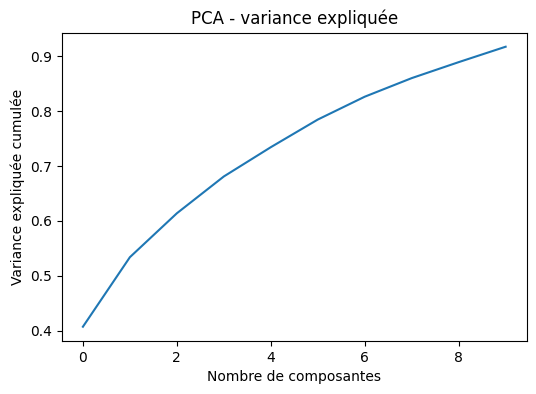

In [76]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('PCA - variance expliquée')
plt.show()

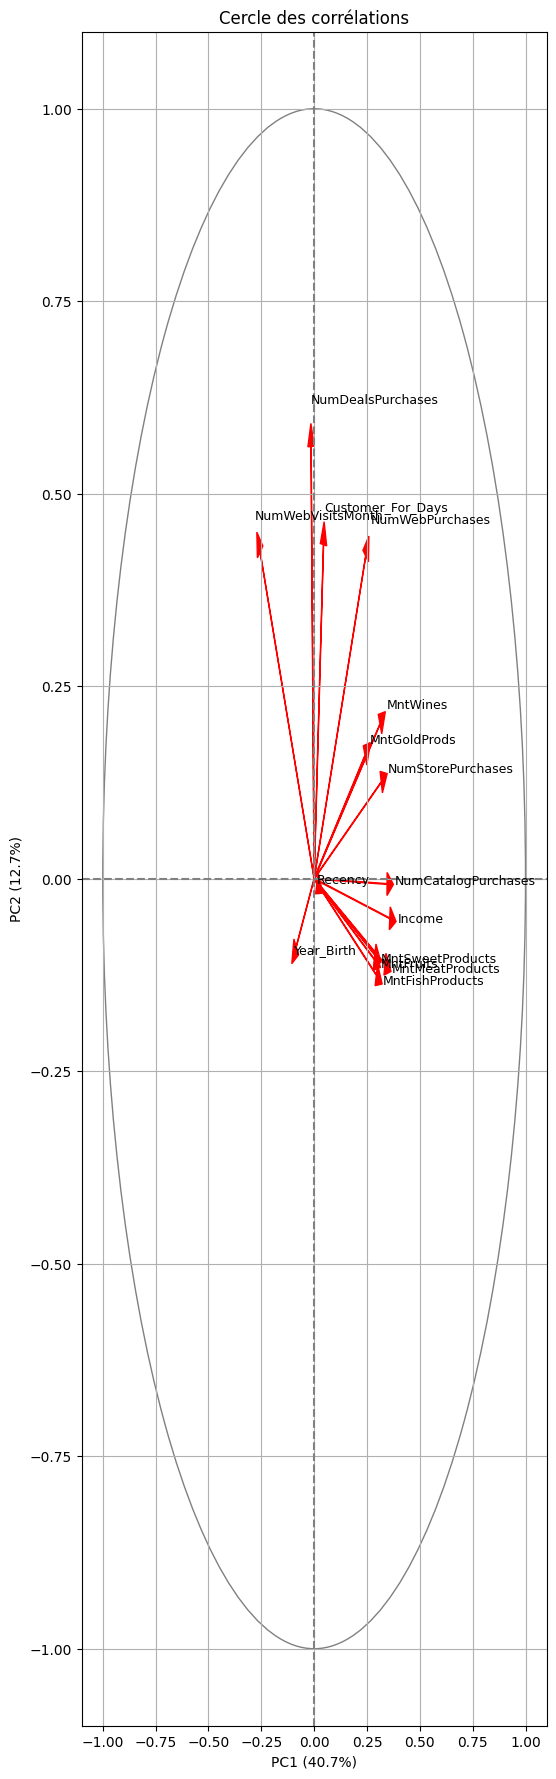

In [80]:
# x_continue = df[['Year_Birth', 'Income', 'Recency', 'MntWines', 'MntFruits',
# 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
# 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
# 'NumCatalogPurchases', 'NumStorePurchases',
# 'NumWebVisitsMonth', 'Customer_For_Days']]
new_features = ['Education','Marital_Status', 'Customer_For_Days','Age', 'Total_Spent', 'Total_Purchases', 'Avg_Order_Value', 
            'Total_Children', 'Total_Campaigns_Accepted']

columns = X_scaled_df.columns  
X = X_scaled  

# ACP
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Cercle de corrélation
pcs = pca.components_

fig, ax = plt.subplots(figsize=(6, 22))

# Cercle unité
circle = plt.Circle((0, 0), 1, color='gray', fill=False)
ax.add_artist(circle)

# Flèches pour chaque variable
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    ax.arrow(0, 0, x, y, head_width=0.03, head_length=0.03, fc='red', ec='red')
    plt.text(x * 1.1, y * 1.1, columns[i], fontsize=9)

# Axes
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')

# Paramètres du graphique
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Cercle des corrélations")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid()
plt.show()


## 4. Méthodes de clustering

In [64]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=4, random_state=0)
labels_kmeans = kmeans.fit_predict(reduced_data)
sil_kmeans = silhouette_score(reduced_data, labels_kmeans)

cah = AgglomerativeClustering(n_clusters=4)
labels_cah = cah.fit_predict(reduced_data)
sil_cah = silhouette_score(reduced_data, labels_cah)

dbscan = DBSCAN(eps=2, min_samples=5)
labels_db = dbscan.fit_predict(reduced_data)
mask = labels_db != -1
sil_db = silhouette_score(reduced_data[mask], labels_db[mask]) if mask.sum() > 1 else np.nan

print('Silhouette K-means:', sil_kmeans)
print('Silhouette CAH:', sil_cah)
print('Silhouette DBSCAN:', sil_db)

Silhouette K-means: 0.141434752946128
Silhouette CAH: 0.10310297001638274
Silhouette DBSCAN: 0.1639327076705203


### Visualisation des clusters (PCA 2D)

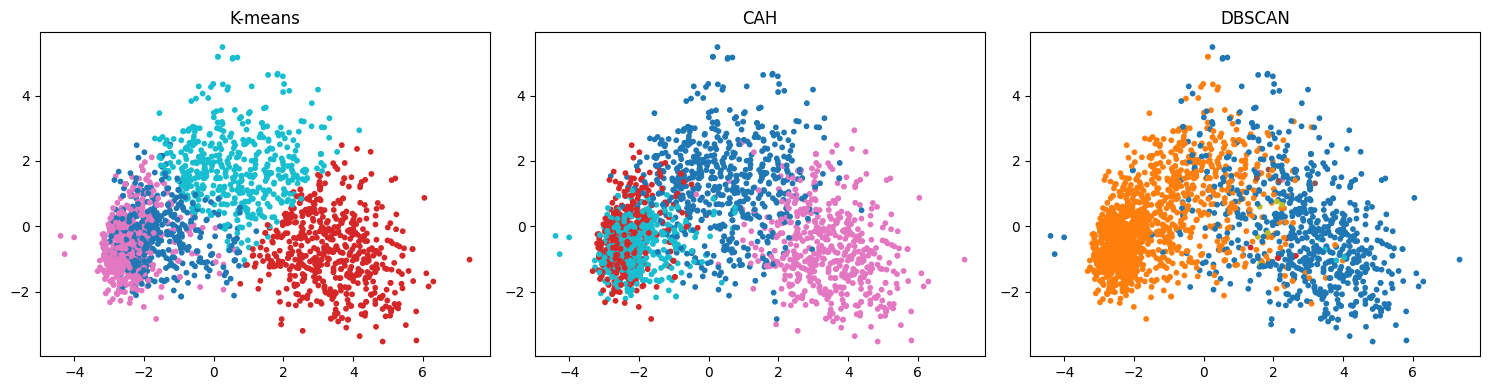

In [65]:
pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(X_final)

fig, axes = plt.subplots(1,3, figsize=(15,4))
for ax, labels, title in zip(axes, [labels_kmeans, labels_cah, labels_db], ['K-means', 'CAH', 'DBSCAN']):
    ax.scatter(reduced_2d[:,0], reduced_2d[:,1], c=labels, cmap='tab10', s=10)
    ax.set_title(title)
plt.tight_layout()
plt.show()

## 5. Profiling des groupes

In [66]:
df_clusters = df.copy()
df_clusters['Cluster_KMeans'] = labels_kmeans
profil_kmeans = df_clusters.groupby('Cluster_KMeans').mean(numeric_only=True)
profil_kmeans

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For_Days,Age,Total_Spent,Total_Purchases,Avg_Order_Value,Total_Children,Total_Campaigns_Accepted
Cluster_KMeans,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1967.367432,3.519833,1.647182,48787.411273,0.469729,0.594990,48.536534,239.668058,19.100209,127.640919,28.417537,21.352818,35.446764,2.377871,3.843424,2.152401,5.373695,5.367432,0.039666,0.048017,0.035491,0.020877,0.002088,0.008351,0.121086,321.889353,56.632568,471.626305,13.747390,24.764892,1.064718,0.267223
1,1969.018416,3.292818,1.618785,55083.902394,0.368324,0.467772,50.629834,338.981584,35.261510,204.987109,48.003683,33.051565,49.108656,2.082873,4.243094,3.099448,6.432781,4.913444,0.066298,0.069982,0.051565,0.040516,0.001842,0.007366,0.110497,353.298343,54.981584,709.394107,15.858195,34.911259,0.836096,0.340700
2,1970.069324,3.325823,1.681109,46413.904679,0.532062,0.464471,50.188908,229.448873,21.109185,123.925477,29.280763,22.246101,35.057192,2.317158,3.630849,2.109185,5.285962,5.663778,0.057192,0.036395,0.024263,0.029463,0.008666,0.012132,0.103986,364.662045,53.930676,461.067591,13.343154,24.158663,0.996534,0.259965
3,1968.432099,3.450617,1.648148,50609.662551,0.469136,0.574074,46.909465,305.450617,22.037037,139.020576,33.477366,22.473251,45.695473,2.658436,4.327160,2.401235,5.860082,5.629630,0.086420,0.065844,0.034979,0.037037,0.008230,0.006173,0.137860,366.314815,55.567901,568.154321,15.246914,28.649609,1.043210,0.370370


## 6. Conclusion

Les différentes méthodes de clustering présentent des performances variables selon le score de silhouette.
Les groupes obtenus peuvent être étudiés au travers des moyennes des variables pour identifier des profils types de clients.